In [1]:
# Display tools
from IPython.display import HTML, display  # For HTML rendering in notebooks
import os 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os

def get_dicom_paths(directory_path, label=None, verbose=True):
    """
    Scans a directory for DICOM (.dcm) files and returns their paths.

    Parameters:
    - directory_path (str): Directory to scan for .dcm files
    - label (str, optional): Label for display (e.g., 'train', 'test')
    - verbose (bool): Whether to print the number of files found

    Returns:
    - List[str]: Paths to DICOM files
    """
    dicom_paths = [
        os.path.join(directory_path, file)
        for file in os.listdir(directory_path)
        if file.lower().endswith('.dcm')
    ]
    
    if verbose:
        label_text = f" in the '{label}' directory" if label else ""
        print(f" Found {len(dicom_paths)} DICOM files{label_text}.")
    
    return dicom_paths

# --- Define Image Directories ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
TEST_IMG_DIR  = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"

# --- Get File Paths ---
train_img_path = get_dicom_paths(TRAIN_IMG_DIR, label="train")
test_img_path  = get_dicom_paths(TEST_IMG_DIR, label="test")


 Found 26684 DICOM files in the 'train' directory.
 Found 3000 DICOM files in the 'test' directory.


In [3]:
labels = pd.read_csv(r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
count_normal = len(labels.loc[labels['Target']==0])
count_pnemonia= len(labels.loc[labels['Target']==1])
traing_count=len(train_img_path)

In [5]:
weight_for_zero =(1/count_normal)*(traing_count)/2.0
weight_for_ones =(1/count_pnemonia)*(traing_count)/2.0

In [93]:
classweight= {0: weight_for_zero,
              1: weight_for_ones}

In [7]:
print("Weights:", classweight)

Weights: {0: 0.6454140866873065, 1: 1.3963369963369963}


In [31]:
def parseMetadata(dcm):  # corrected from 'paraseMetadata'
    unpackedData = {}
    groupElemToKeywords = {}
    
    for d in dcm:  # This forces conversion from lazy RawDataElement to DataElement
        pass

    # Un-pack Data
    for tag, elem in dcm.items():
        tagGroup = tag.group
        tagElem = tag.elem
        keyword = elem.keyword
        groupElemToKeywords[(tagGroup, tagElem)] = keyword
        value = elem.value
        unpackedData[keyword] = value
        
    return unpackedData, groupElemToKeywords


In [14]:
import pydicom
from tqdm import tqdm

In [52]:


# Step 1: Read DICOM files from paths
train_dcms = [pydicom.dcmread(path) for path in tqdm(train_img_path[:5000])]
test_dcms = [pydicom.dcmread(path) for path in tqdm(test_img_path[:5000])]




  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [01:06<00:00, 45.09it/s]


In [53]:
# Step 2: Parse metadata from DICOM datasets
trainMetaDicts, trainKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(train_dcms)])
testMetaDicts, testKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(test_dcms)])

100%|██████████| 3000/3000 [00:05<00:00, 576.96it/s]


In [54]:
def createY(df):
    """
    Returns binary labels: 1 if 'SeriesDescription' is 'view: PA', else 0.
    """
    if 'SeriesDescription' not in df.columns:
        raise ValueError("Missing 'SeriesDescription' column in DataFrame.")
    
    return (df['SeriesDescription'] == 'view: PA').astype(int).values


In [55]:
train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
test_df = pd.DataFrame.from_dict(data=testMetaDicts)

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

train_Y = createY(train_df)
test_Y = createY(test_df)


In [110]:
test_Y

array([1, 1, 1, ..., 1, 1, 1])

In [56]:
def decodeImage(filePath):
    image = pydicom.dcmread(filePath).pixel_array
    image = cv2.resize(image, (64, 64))
    return image / 255.0


In [57]:

import cv2
import numpy as np

# Get our train x in the correct shape
train_X = []

for filePath in tqdm(train_img_path[:5000]):
    
    img = decodeImage(filePath)
    train_X.append(img)

train_X = np.array(train_X) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [01:48<00:00, 46.14it/s]


In [58]:
train_X_rgb

array([[[[0.01176471, 0.01176471, 0.01176471],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.0745098 , 0.0745098 , 0.0745098 ]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.00392157]],

        ...,

        [[0.01176471, 0.01176471, 0.01176471],
         [0.00784314, 0.00784314, 0.00784314]

In [59]:
test_X =[]
for filePath in tqdm(test_img_path[:5000]):
    
    img = decodeImage(filePath)
    test_X.append(img)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

  0%|          | 4/3000 [00:00<01:31, 32.89it/s]

100%|██████████| 3000/3000 [01:08<00:00, 43.74it/s]


In [105]:
import matplotlib.pyplot as plt

def plot_score(hist):
    fig, ax = plt.subplots(5, 1, figsize=(10, 20))  # Corrected 'subplot' to 'subplots'
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'precision', 'recall', 'AUC', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title(f'Model {met}')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()


In [29]:
!pip install tensorflow 

In [30]:
import tensorflow as tf

In [109]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model


In [25]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]

In [50]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

Baseline Model CNN

In [116]:
import tensorflow as tf

def build_fcnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [117]:
model_fcnn=build_fcnn_model()


c:\Users\samya\PyCharmProject\Pneumonia-Detection\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [118]:
model_fcnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,121 (6.00 MB)

 Trainable params: 1,573,121 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
model_fcnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [120]:
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format
history_fcnn = model_fcnn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 100,
                          batch_size = 128,
                          validation_split = 0.15, 
                          class_weight = classweight, 
                          verbose = 1,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]) # Fit the model

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - AUC: 0.8706 - accuracy: 0.6232 - loss: 16.9213 - precision: 0.8301 - recall: 0.9066 - val_AUC: 0.6565 - val_accuracy: 0.6000 - val_loss: 4.6202 - val_precision: 0.5757 - val_recall: 0.9926 - learning_rate: 0.0100
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - AUC: 0.8201 - accuracy: 0.7767 - loss: 1.4083 - precision: 0.7524 - recall: 0.8896 - val_AUC: 0.9351 - val_accuracy: 0.8813 - val_loss: 0.5044 - val_precision: 0.8661 - val_recall: 0.9236 - learning_rate: 0.0089
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - AUC: 0.9314 - accuracy: 0.8538 - loss: 0.5058 - precision: 0.8295 - recall: 0.9235 - val_AUC: 0.9220 - val_accuracy: 0.7893 - val_loss: 0.8916 - val_precision: 0.9733 - val_recall: 0.6281 - learning_rate: 0.0079
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - AUC: 0.8744 - accuracy: 0.7982 - loss: 0.7784 - precision: 0.7820 - recall: 0.8778 - val_AUC: 0.9290 - val_accuracy: 0.8253 - val_loss: 0.7341 - va

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.9690 - accuracy: 0.9134 - loss: 0.2268 - precision: 0.9095 - recall: 0.9300
{'loss': 0.2224535495042801, 'compile_metrics': 0.9139999747276306}


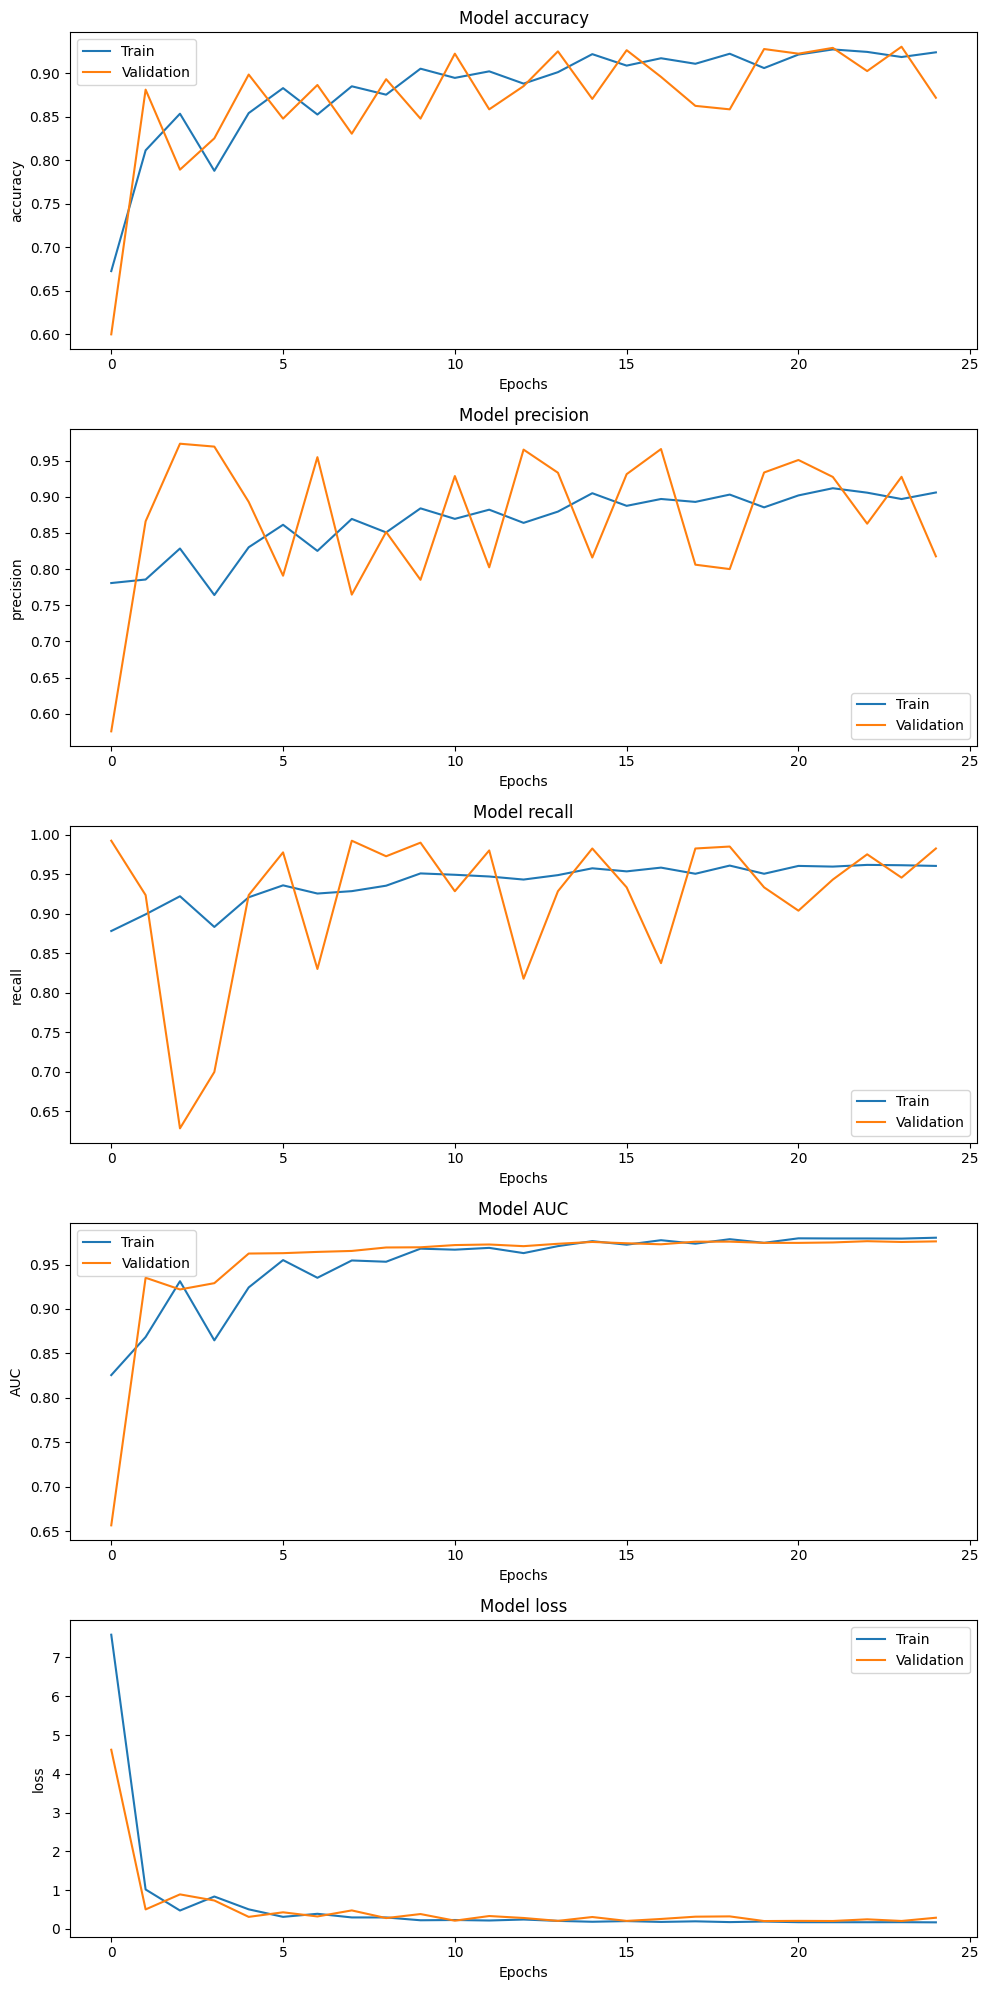

In [121]:
# Evaluate and display results
results = model_fcnn.evaluate(test_X_rgb, test_Y) # Evaluate the model on test data
results = dict(zip(model_fcnn.metrics_names,results))

print(results)
plot_score(history_fcnn) # Visualise scores

In [62]:
import tensorflow as tf
import numpy as np

# Define the model
def Cust_Cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model



In [99]:
import tensorflow as tf

def Cust_Cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model


In [100]:

# Instantiate the model
model_cnn = Cust_Cnn_model()


In [102]:

# Print model summary
model_cnn.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,274,945 (4.86 MB)

 Trainable params: 1,274,177 (4.86 MB)

 Non-trainable params: 768 (3.00 KB)

In [103]:

# Compile the model
model_cnn.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)


In [114]:
# Fit model
history_cnn = model_cnn.fit(train_X_rgb, 
                      train_Y,  
                      epochs=100, 
                      validation_split = 0.15, 
                      batch_size=128,
                      class_weight=classweight,
                      callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
                      verbose=1) # Fit the model

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 623ms/step - AUC: 0.9909 - accuracy: 0.9574 - loss: 0.1024 - precision: 0.9433 - recall: 0.9786 - val_AUC: 0.9679 - val_accuracy: 0.7427 - val_loss: 0.7492 - val_precision: 0.6784 - val_recall: 0.9975 - learning_rate: 0.0100
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 648ms/step - AUC: 0.9885 - accuracy: 0.9582 - loss: 0.1170 - precision: 0.9429 - recall: 0.9831 - val_AUC: 0.7340 - val_accuracy: 0.5560 - val_loss: 2.5207 - val_precision: 0.5495 - val_recall: 0.9975 - learning_rate: 0.0089
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - AUC: 0.9932 - accuracy: 0.9657 - loss: 0.0939 - precision: 0.9643 - recall: 0.9737

34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 614ms/step - AUC: 0.9932 - accuracy: 0.9657 - loss: 0.0940 - precision: 0.9642 - recall: 0.9738 - val_AUC: 0.9560 - val_accuracy: 0.8627 - val_loss: 0.3964 - val_precision: 0.9522 - val_recall: 0.7857 - learning_rate: 0.0079
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - AUC: 0.9944 - accuracy: 0.9697 - loss: 0.0757 - precision: 0.9626 - recall: 0.9823

34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 656ms/step - AUC: 0.9945 - accuracy: 0.9698 - loss: 0.0755 - precision: 0.9627 - recall: 0.9823 - val_AUC: 0.9622 - val_accuracy: 0.9120 - val_loss: 0.2864 - val_precision: 0.9359 - val_recall: 0.8990 - learning_rate: 0.0071
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - AUC: 0.9957 - accuracy: 0.9830 - loss: 0.0586 - precision: 0.9805 - recall: 0.9887

34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 680ms/step - AUC: 0.9957 - accuracy: 0.9829 - loss: 0.0586 - precision: 0.9804 - recall: 0.9887 - val_AUC: 0.9649 - val_accuracy: 0.9040 - val_loss: 0.2640 - val_precision: 0.9282 - val_recall: 0.8916 - learning_rate: 0.0063
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 681ms/step - AUC: 0.9963 - accuracy: 0.9832 - loss: 0.0524 - precision: 0.9805 - recall: 0.9889 - val_AUC: 0.9386 - val_accuracy: 0.7347 - val_loss: 0.9709 - val_precision: 0.6711 - val_recall: 1.0000 - learning_rate: 0.0056
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - AUC: 0.9978 - accuracy: 0.9801 - loss: 0.0486 - precision: 0.9768 - recall: 0.9866

34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 659ms/step - AUC: 0.9978 - accuracy: 0.9802 - loss: 0.0485 - precision: 0.9769 - recall: 0.9866 - val_AUC: 0.9904 - val_accuracy: 0.9600 - val_loss: 0.1295 - val_precision: 0.9498 - val_recall: 0.9778 - learning_rate: 0.0050
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - AUC: 0.9980 - accuracy: 0.9859 - loss: 0.0386 - precision: 0.9840 - recall: 0.9905

34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 706ms/step - AUC: 0.9979 - accuracy: 0.9859 - loss: 0.0387 - precision: 0.9840 - recall: 0.9905 - val_AUC: 0.9916 - val_accuracy: 0.9733 - val_loss: 0.1044 - val_precision: 0.9754 - val_recall: 0.9754 - learning_rate: 0.0045
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 677ms/step - AUC: 0.9963 - accuracy: 0.9797 - loss: 0.0490 - precision: 0.9718 - recall: 0.9914 - val_AUC: 0.9542 - val_accuracy: 0.8840 - val_loss: 0.4982 - val_precision: 0.9790 - val_recall: 0.8030 - learning_rate: 0.0040
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 668ms/step - AUC: 0.9980 - accuracy: 0.9819 - loss: 0.0473 - precision: 0.9782 - recall: 0.9891 - val_AUC: 0.9540 - val_accuracy: 0.8067 - val_loss: 0.6234 - val_precision: 0.7403 - val_recall: 0.9901 - learning_rate: 0.0035
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - AUC: 0.9956 - accuracy: 0.9806 - loss: 0.0583 - precision: 0.9816 - recall: 0.9841

34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 639ms/step - AUC: 0.9956 - accuracy: 0.9806 - loss: 0.0581 - precision: 0.9815 - recall: 0.9843 - val_AUC: 0.9975 - val_accuracy: 0.9853 - val_loss: 0.0472 - val_precision: 0.9950 - val_recall: 0.9778 - learning_rate: 0.0032
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 670ms/step - AUC: 0.9972 - accuracy: 0.9903 - loss: 0.0380 - precision: 0.9885 - recall: 0.9939 - val_AUC: 0.9809 - val_accuracy: 0.8867 - val_loss: 0.3760 - val_precision: 0.9969 - val_recall: 0.7931 - learning_rate: 0.0028
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 625ms/step - AUC: 0.9988 - accuracy: 0.9910 - loss: 0.0272 - precision: 0.9883 - recall: 0.9956 - val_AUC: 0.9944 - val_accuracy: 0.9613 - val_loss: 0.1175 - val_precision: 0.9974 - val_recall: 0.9310 - learning_rate: 0.0025
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 676ms/step - AUC: 0.9995 - accuracy: 0.9939 - loss: 0.0225 - precision: 0.9911 - recall: 0.9974 - val_AUC: 0.9906 - val_accuracy: 0.9587 - val_loss: 0.1202 - val_

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - AUC: 0.9961 - accuracy: 0.9794 - loss: 0.0768 - precision: 0.9916 - recall: 0.9695
Test Results: {'loss': 0.06415965408086777, 'compile_metrics': 0.9806666374206543}


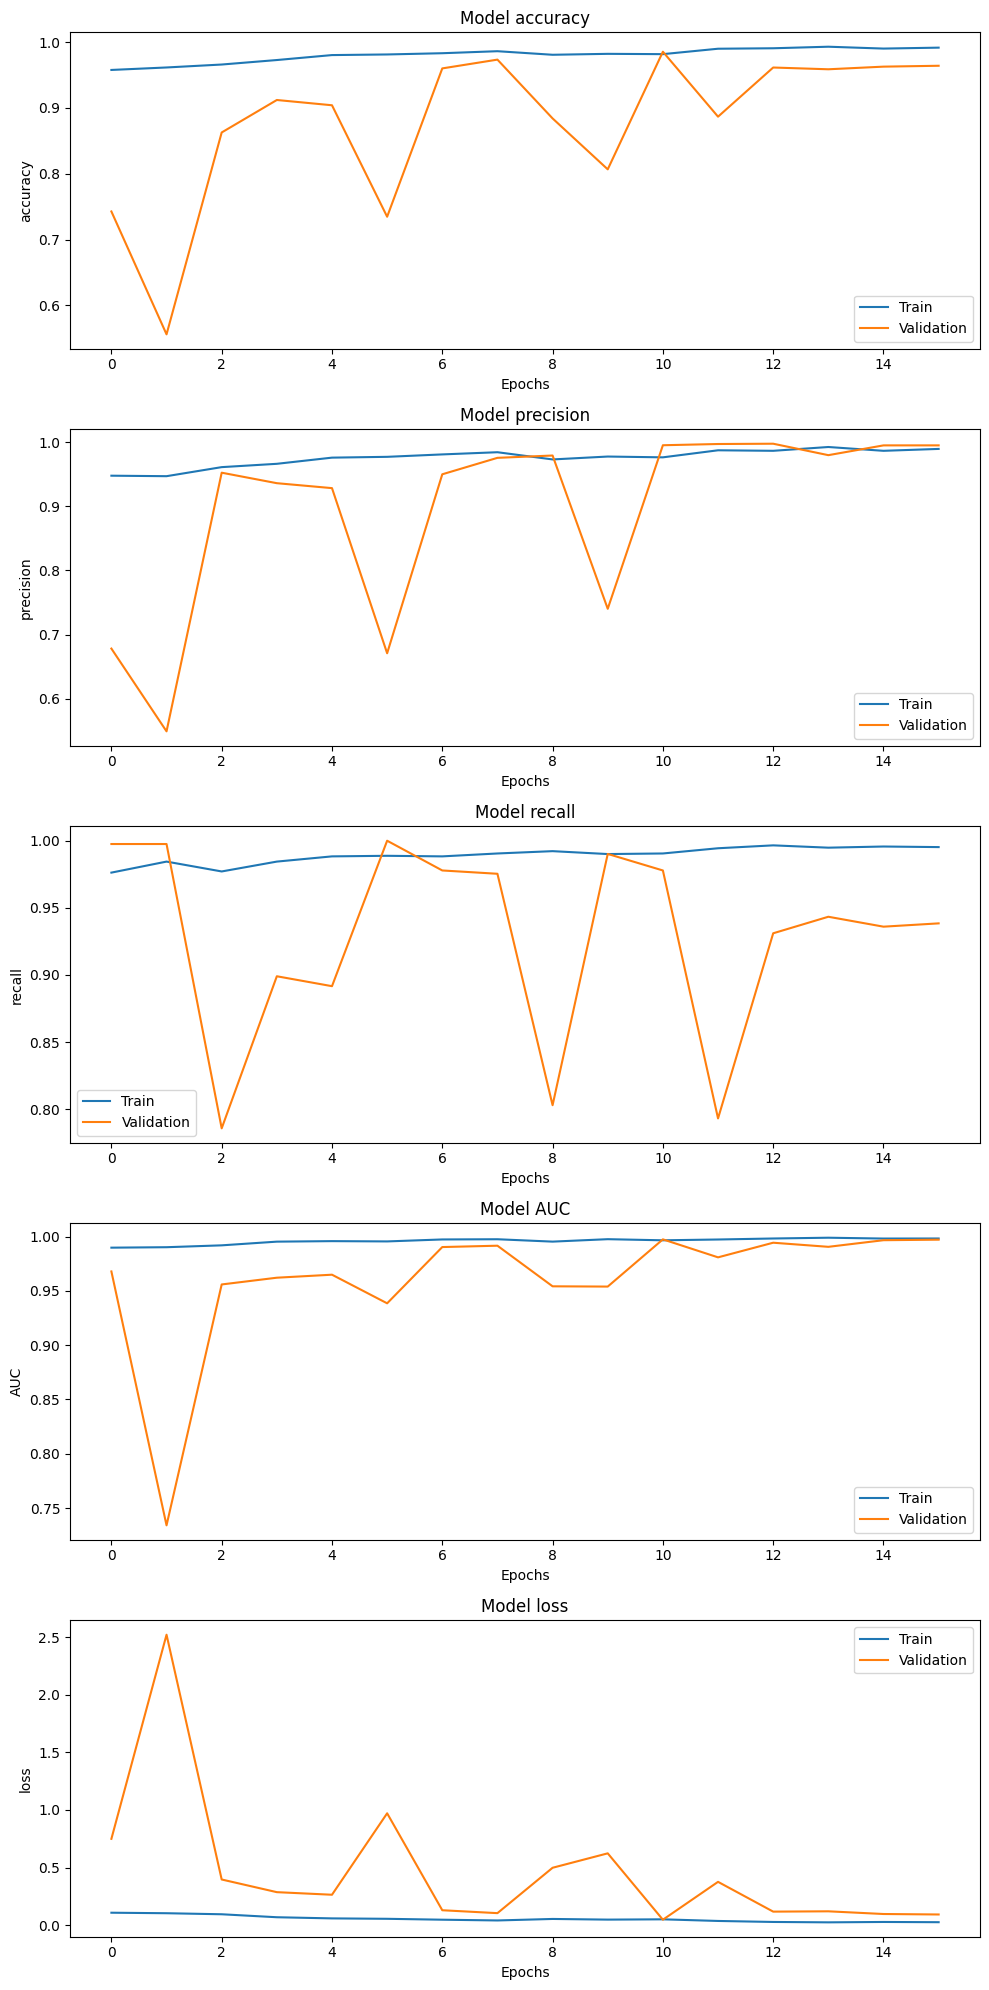

In [115]:
# Evaluate the trained model on test data
results = model_cnn.evaluate(test_X_rgb, test_Y, verbose=1)

# Convert results to a dictionary for readability
results_dict = dict(zip(model_cnn.metrics_names, results))
print("Test Results:", results_dict)

# Visualize training history
plot_score(history_cnn)
